In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
# load the original monrach kg graph from the triple lists
# ELs_for_Rotate/Monarch_KG/test.txt  ELs_for_Rotate/Monarch_KG/train.txt  ELs_for_Rotate/Monarch_KG/valid.txt
def get_G(train, valid, test):
    train_triples = pd.read_csv(train, sep='\t', header=None)
    test_triples = pd.read_csv(test, sep='\t', header=None)
    validation_triples = pd.read_csv(valid, sep='\t', header=None)
    all_triples = pd.concat([train_triples, test_triples, validation_triples])

    # create a graph from the triples
    G = nx.from_pandas_edgelist(all_triples, 0, 2)
    return G

monarch_G = get_G('../ELs_for_Rotate/Monarch_KG/train.txt', '../ELs_for_Rotate/Monarch_KG/valid.txt', '../ELs_for_Rotate/Monarch_KG/test.txt')

In [5]:
# get the 10 highest degree HGNC nodes
HGNC_nodes = [node for node in monarch_G.nodes if 'HGNC' in node]
HGNC_degrees = [(node, monarch_G.degree(node)) for node in HGNC_nodes]
HGNC_degrees.sort(key=lambda x: x[1], reverse=True)
top_10_HGNC_nodes = [node for node, degree in HGNC_degrees[:10]]
print(top_10_HGNC_nodes)

# get all the HGNC genes in G
background_genes = [node for node in monarch_G.nodes if 'HGNC' in node]

# create a dictionary of all HGNC and their associated GO: terms
HGNC_GO = {}
for node in background_genes:
    if 'HGNC' in node:
        HGNC_GO[node] = set([neighbor for neighbor in monarch_G.neighbors(node) if 'GO:' in neighbor])

# make a dataframe of the node name, degree, and degree percentile
HGNC_degrees_df = pd.DataFrame(HGNC_degrees, columns=['HGNC', 'degree'])
HGNC_degrees_df['degree_percentile'] = HGNC_degrees_df['degree'].rank(pct=True)
print(HGNC_degrees_df.head())
print(HGNC_degrees_df.tail())


['HGNC:31859', 'HGNC:18224', 'HGNC:8607', 'HGNC:3236', 'HGNC:6407', 'HGNC:7553', 'HGNC:14339', 'HGNC:24500', 'HGNC:11998', 'HGNC:1591']
         HGNC  degree  degree_percentile
0  HGNC:31859    4997           1.000000
1  HGNC:18224    4189           0.999953
2   HGNC:8607    3661           0.999906
3   HGNC:3236    3517           0.999860
4   HGNC:6407    3503           0.999813
             HGNC  degree  degree_percentile
21354  HGNC:37491       1            0.02067
21355  HGNC:44662       1            0.02067
21356  HGNC:55318       1            0.02067
21357  HGNC:33789       1            0.02067
21358  HGNC:28305       1            0.02067


In [30]:
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations

# Download ontology and annotations if not already present
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()

# Load gene ontology
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

# # Load associations between genes and GO terms
# from goatools.associations import read_ncbi_gene2go
# geneid2gos_human = read_ncbi_gene2go("gene2go", taxids=[9606])

# Create a GO enrichment study object
goeaobj = GOEnrichmentStudy(
    background_genes,  # list of all human genes
    HGNC_GO,  # gene2go dictionary
    obodag,            # gene ontology DAG
    propagate_counts=True,
    alpha=0.05,
    methods=['fdr_bh'])

significance_threshold = 0.05
# Run the enrichment analysis
# count number of enriched terms for genes in the top x% of degrees, incrementing by 5%
enrichment_results = {'percentile':[], 'num_enriched_terms':[], 'num_genes':[]}
for i in range(0, 101, 5):
    print(i)
    threshold = HGNC_degrees_df['degree_percentile'].quantile(i/100)
    genes_above_threshold = HGNC_degrees_df[HGNC_degrees_df['degree_percentile'] > threshold]['HGNC']
    goea_results_all = goeaobj.run_study(genes_above_threshold)
    significant_count = sum(1 for result in goea_results_all if result.p_fdr_bh < significance_threshold)
    enrichment_results['percentile'].append(i)
    enrichment_results['num_enriched_terms'].append(significant_count)
    enrichment_results['num_genes'].append(len(genes_above_threshold))

enrichment_results_df = pd.DataFrame(enrichment_results)
print(enrichment_results_df)


  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a


69 GO IDs NOT FOUND IN ASSOCIATION: GO:0052593 GO:0044595 GO:0018142 GO:0038008 GO:0034972 GO:0071712 GO:0008689 GO:1903070 GO:0047409 GO:0016290 GO:0052594 GO:0031062 GO:0004320 GO:0070932 GO:0044596 GO:0035067 GO:0007228 GO:0051571 GO:0009444 GO:0097344 GO:0071847 GO:0035065 GO:0035998 GO:1900111 GO:0034729 GO:1903069 GO:0033182 GO:0070423 GO:0031065 GO:0051570 GO:0061811 GO:0071557 GO:0043430 GO:0042788 GO:0090226 GO:0005844 GO:0016295 GO:0016573 GO:1903071 GO:0043333 GO:0035066 GO:0043966 GO:0016575 GO:0061290 GO:0005845 GO:0044736 GO:0047381 GO:0019932 GO:0004395 GO:1904379 GO:0061812 GO:0044466 GO:0102040 GO:0034968 GO:0006407 GO:0051568 GO:0016296 GO:0016570 GO:0102991 GO:0030433 GO:0052596 GO:0019800 GO:0007227 GO:0009917 GO:0071848 GO:0016571 GO:0043734 GO:0009918 GO:2000620


100% 21,359 of 21,359 population items found in association

Runing  Ontology Analysis: current study set of 20477 IDs.
100% 20,477 of 20,477 study items found in association
100% 20,477 of 20,477 study items found in population(21359)
Calculating 21,961 uncorrected p-values using fisher_scipy_stats
  21,961 terms are associated with 19,417 of 21,359 population items
  21,961 terms are associated with 19,334 of 20,477 study items
  METHOD fdr_bh:
   1,276 GO terms found significant (< 0.05=alpha) (1276 enriched +   0 purified): statsmodels fdr_bh
  19,334 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing  Ontology Analysis: current study set of 20173 IDs.
100% 20,173 of 20,173 study items found in association
100% 20,173 of 20,173 study items found in population(21359)
Calculating 21,961 uncorrected p-values using fisher_scipy_stats
  21,961 terms are associated with 19,417 of 21,359 population items
  2

# plot degree percentile vs # enriched terms
# plot degree percentile vs # number of nodes

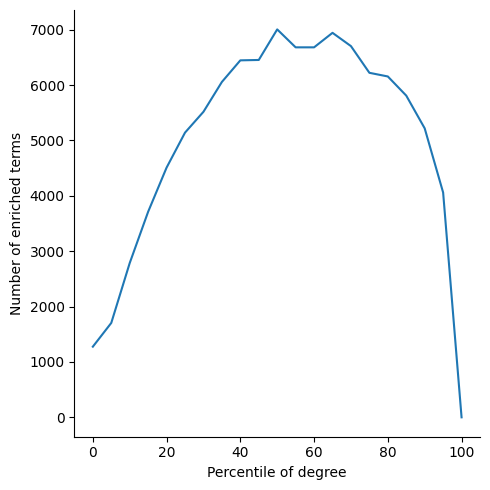

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))

# plot the number of enriched terms vs the percentile of genes
ax.plot(enrichment_results_df['percentile'], enrichment_results_df['num_enriched_terms'])
ax.set_xlabel('Percentile of degree')
ax.set_ylabel('Number of enriched terms')
# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../Figures/gene_degree_vs_enrichment.monarch.png',dpi=300)
plt.show()


# experiment:
Establish bins of genes (size 25?) based on degree, do enrichment for each bin. I assuming enrichment as a whole drops off at a certain point, does it re-immerage at low degree areas?

In [47]:
binned_enrichment_results = {'bin':[], 'num_enriched_terms':[], 'members':[]}
for i in range(0, HGNC_degrees_df.shape[0], 100):
    print(i)
    genes_in_bin = HGNC_degrees_df['HGNC'].iloc[i:i+100]
    goea_results_all = goeaobj.run_study(genes_in_bin)
    significant_count = sum(1 for result in goea_results_all if result.p_fdr_bh < significance_threshold)
    binned_enrichment_results['bin'].append(i)
    binned_enrichment_results['num_enriched_terms'].append(significant_count)
    binned_enrichment_results['members'].append(str(genes_in_bin))

binned_enrichment_results_df = pd.DataFrame(binned_enrichment_results)
print(binned_enrichment_results_df)
# save the df
binned_enrichment_results_df.to_csv('gene_degree_vs_enrichment_by_bin.monarch_.csv', index=False)

       bin  num_enriched_terms  \
0        0                1307   
1      100                 873   
2      200                 692   
3      300                 670   
4      400                 617   
..     ...                 ...   
209  20900                 146   
210  21000                 146   
211  21100                 145   
212  21200                 144   
213  21300                  72   

                                               members  
0    0     HGNC:31859\n1     HGNC:18224\n2      HGN...  
1    100     HGNC:8127\n101    HGNC:13557\n102    H...  
2    200     HGNC:2092\n201    HGNC:11427\n202     ...  
3    300    HGNC:12648\n301     HGNC:5046\n302     ...  
4    400     HGNC:5036\n401     HGNC:3091\n402    H...  
..                                                 ...  
209  20900     HGNC:4143\n20901     HGNC:4159\n2090...  
210  21000    HGNC:54402\n21001    HGNC:35346\n2100...  
211  21100    HGNC:50687\n21101    HGNC:38825\n2110...  
212  21200    HGNC:32

In [12]:
import numpy as np
# load binned_enrichment_results_df.to_csv('gene_degree_vs_enrichment_by_bin.monarch_.csv', index=False)
binned_enrichment_results_df = pd.read_csv('gene_degree_vs_enrichment_by_bin.monarch_.csv')

median_num_GO_terms = []
total_num_GO_terms = []
for i in range(0, HGNC_degrees_df.shape[0], 100):
    if i % 1000 == 0:
        print(i)
    genes_in_bin = HGNC_degrees_df['HGNC'].iloc[i:i+100]
    # get the number of GO terms associated with the genes in the bin
    go_terms_in_bin = list()
    for gene in genes_in_bin:
        go_terms_in_bin.append(len(HGNC_GO[gene]))
    median_num_GO_terms.append(np.median(go_terms_in_bin))
    total_num_GO_terms.append(np.sum(go_terms_in_bin))

binned_enrichment_results_df['median_num_GO_terms'] = median_num_GO_terms
binned_enrichment_results_df['total_num_GO_terms'] = total_num_GO_terms

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


/tmp/ipykernel_121833/3029351643.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[2].set_ylim(bottom=0)


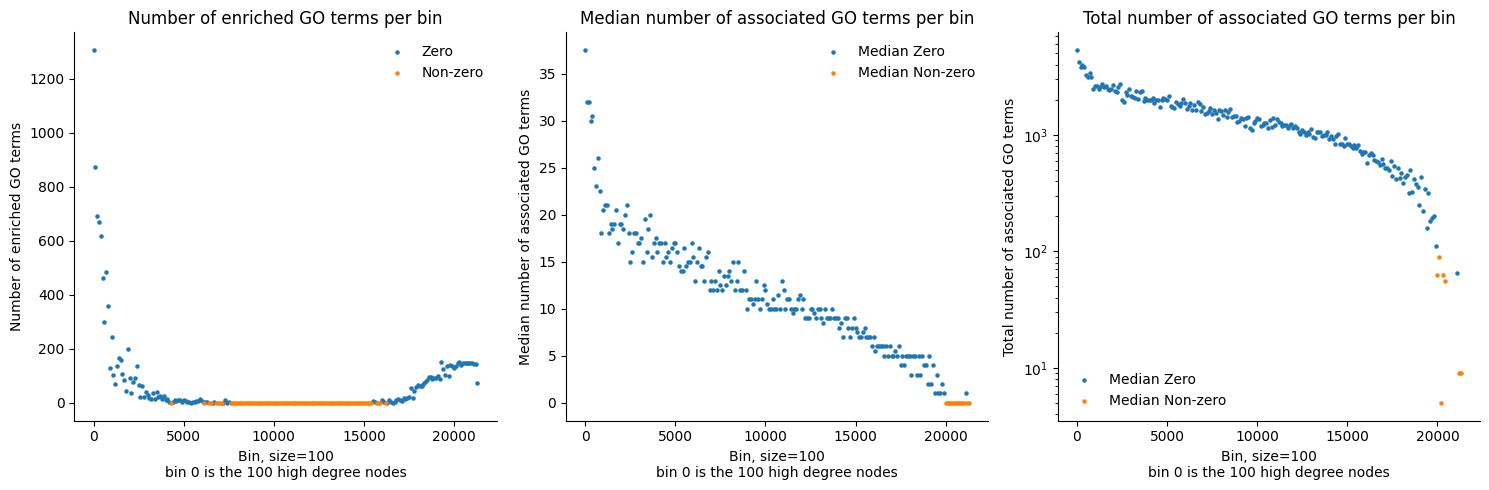

In [36]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))

binned_enrichment_results_df['median_is_zero'] = binned_enrichment_results_df['median_num_GO_terms'] == 0
binned_enrichment_results_df['num_enriched_terms_is_zero'] = binned_enrichment_results_df['num_enriched_terms'] == 0

# plot the median number of associated GO terms vs the number of enriched terms
sub = binned_enrichment_results_df[binned_enrichment_results_df['median_is_zero'] == False]
axes[1].scatter(sub['bin'], sub['median_num_GO_terms'],label='Median > 0',s=5)
sub = binned_enrichment_results_df[binned_enrichment_results_df['median_is_zero'] == True]
axes[1].scatter(sub['bin'], sub['median_num_GO_terms'],label='Median == 0',s=5)
axes[1].set_xlabel('Bin, size=100\nbin 0 is the 100 high degree nodes')
axes[1].set_ylabel('Median number of associated GO terms')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].legend(['Median Zero','Median Non-zero'],loc='upper right',frameon=False)
axes[1].set_title('Median number of associated GO terms per bin')

# plot the total number of GO terms vs the percentile of genes
sub = binned_enrichment_results_df[binned_enrichment_results_df['median_is_zero'] == False]
axes[2].scatter(sub['bin'], sub['total_num_GO_terms'],label='Median > 0',s=5)
sub = binned_enrichment_results_df[binned_enrichment_results_df['median_is_zero'] == True]
axes[2].scatter(sub['bin'], sub['total_num_GO_terms'],label='Median == 0',s=5)
axes[2].set_xlabel('Bin, size=100\nbin 0 is the 100 high degree nodes')
axes[2].set_ylabel('Total number of associated GO terms')
axes[2].set_title('Total number of associated GO terms per bin')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_yscale('log')
axes[2].set_ylim(bottom=0)
axes[2].legend(['Median Zero','Median Non-zero'],loc='lower left',frameon=False)

# plot all non-zero bins
sub = binned_enrichment_results_df[binned_enrichment_results_df['num_enriched_terms'] > 0]
axes[0].scatter(sub['bin'], sub['num_enriched_terms'],label='Non-zero',s=5)
sub = binned_enrichment_results_df[binned_enrichment_results_df['num_enriched_terms'] == 0]
axes[0].scatter(sub['bin'], sub['num_enriched_terms'],label='Zero',s=5)
axes[0].set_xlabel('Bin, size=100\nbin 0 is the 100 high degree nodes')
axes[0].set_ylabel('Number of enriched GO terms')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title('Number of enriched GO terms per bin')
axes[0].legend(['Zero','Non-zero'],loc='upper right',frameon=False)

plt.tight_layout()
plt.savefig('../Figures/gene_degree_vs_enrichment_by_bin.monarch.png',dpi=300)
plt.show()

In [45]:
import re

from goatools.go_enrichment import GOEnrichmentStudy
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations

# Download ontology and annotations if not already present
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()

# Load gene ontology
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

# # Load associations between genes and GO terms
# from goatools.associations import read_ncbi_gene2go
# geneid2gos_human = read_ncbi_gene2go("gene2go", taxids=[9606])

# Create a GO enrichment study object
goeaobj = GOEnrichmentStudy(
    background_genes,  # list of all human genes
    HGNC_GO,  # gene2go dictionary
    obodag,            # gene ontology DAG
    propagate_counts=True,
    alpha=0.05,
    methods=['fdr_bh'])

significance_threshold = 0.05

# get the bottom 10 bins
binned_enrichment_results_df.tail(10)
start = HGNC_degrees_df.shape[0] - ((HGNC_degrees_df.shape[0] // 100) * 10)
for i in range(start, HGNC_degrees_df.shape[0], 100):
    if i % 1000 == 0:
        print(i)
    genes_in_bin = HGNC_degrees_df['HGNC'].iloc[i:i+100].tolist()
    print(genes_in_bin)
    goea_results_all = goeaobj.run_study(genes_in_bin)
    # print each result that is below the significance threshold
    for result in goea_results_all:
        if result.p_fdr_bh < significance_threshold:
            print(result)
    print('\n')
    # significant_count = sum(1 for result in goea_results_all if result.p_fdr_bh < significance_threshold)
    
    


  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a


69 GO IDs NOT FOUND IN ASSOCIATION: GO:0016575 GO:0051570 GO:0043333 GO:0070932 GO:0090226 GO:0044736 GO:0005845 GO:0035066 GO:0044595 GO:2000620 GO:0005844 GO:1904379 GO:0008689 GO:0019800 GO:1903069 GO:0030433 GO:0034968 GO:0034729 GO:0004320 GO:0035998 GO:0006407 GO:0042788 GO:0016296 GO:0035065 GO:0016295 GO:0043734 GO:0044596 GO:0052594 GO:0052596 GO:0043430 GO:0051571 GO:0097344 GO:0034972 GO:0071712 GO:0061290 GO:0031065 GO:0071848 GO:0019932 GO:0033182 GO:1903071 GO:1903070 GO:0052593 GO:0043966 GO:0007227 GO:1900111 GO:0016290 GO:0007228 GO:0071557 GO:0016571 GO:0009918 GO:0102991 GO:0031062 GO:0061812 GO:0009917 GO:0070423 GO:0047409 GO:0009444 GO:0047381 GO:0051568 GO:0061811 GO:0038008 GO:0004395 GO:0016570 GO:0044466 GO:0035067 GO:0016573 GO:0102040 GO:0071847 GO:0018142


100% 21,359 of 21,359 population items found in association
['HGNC:13670', 'HGNC:31653', 'HGNC:19155', 'HGNC:30803', 'HGNC:10211', 'HGNC:32545', 'HGNC:32688', 'HGNC:28479', 'HGNC:26665', 'HGNC:44310', 'HGNC:33969', 'HGNC:14332', 'HGNC:16707', 'HGNC:28712', 'HGNC:24958', 'HGNC:29575', 'HGNC:14676', 'HGNC:28397', 'HGNC:38749', 'HGNC:5607', 'HGNC:21403', 'HGNC:25704', 'HGNC:15025', 'HGNC:30846', 'HGNC:25312', 'HGNC:19290', 'HGNC:16167', 'HGNC:26236', 'HGNC:49189', 'HGNC:44112', 'HGNC:24462', 'HGNC:37204', 'HGNC:33736', 'HGNC:31988', 'HGNC:28285', 'HGNC:8517', 'HGNC:30780', 'HGNC:16880', 'HGNC:32350', 'HGNC:49396', 'HGNC:33858', 'HGNC:15801', 'HGNC:4253', 'HGNC:20267', 'HGNC:19136', 'HGNC:26536', 'HGNC:15355', 'HGNC:19705', 'HGNC:37096', 'HGNC:35445', 'HGNC:21315', 'HGNC:18319', 'HGNC:30079', 'HGNC:40283', 'HGNC:40043', 'HGNC:2096', 'HGNC:30454', 'HGNC:37215', 'HGNC:4213', 'HGNC:14722', 'HGNC:31791', 'HGNC:16213', 'HGNC:12188', 'HGNC:27885', 'HGNC:53269', 'HGNC:19632', 'HGNC:2332', 'HGNC:3

# Are there terms in the bottom 100 that are not enriched anywhere else?

There are 8 go terms enriched exclusively in the bottom 100 bins.

In [58]:
# term: [bin1,bin100,bin37...]
GO_terms_dict = {}
GO_id_to_name = {}
for i in range(0, HGNC_degrees_df.shape[0], 100):
    if i % 1000 == 0:
        print(i)
    genes_in_bin = HGNC_degrees_df['HGNC'].iloc[i:i+100].tolist()
    goea_results_all = goeaobj.run_study(genes_in_bin)
    for result in goea_results_all:
        if result.p_fdr_bh < significance_threshold:
            if result.GO in GO_terms_dict:
                GO_terms_dict[result.GO].append(i)
            else:
                print(result.GO)
                print(result.name)
                GO_terms_dict[result.GO] = [i]
                GO_id_to_name[result.GO] = result.name

import pickle
with open('GO_terms_dict.pickle', 'wb') as handle:
    pickle.dump(GO_terms_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

0

Runing  Ontology Analysis: current study set of 100 IDs.
100%    100 of    100 study items found in association
100%    100 of    100 study items found in population(21359)
Calculating 21,961 uncorrected p-values using fisher_scipy_stats
  21,961 terms are associated with 19,417 of 21,359 population items
   4,952 terms are associated with     99 of    100 study items
  METHOD fdr_bh:
   1,307 GO terms found significant (< 0.05=alpha) (1307 enriched +   0 purified): statsmodels fdr_bh
      99 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
GO:0051173
positive regulation of nitrogen compound metabolic process
GO:0010604
positive regulation of macromolecule metabolic process
GO:0009893
positive regulation of metabolic process
GO:0051716
cellular response to stimulus
GO:0051246
regulation of protein metabolic process
GO:0051171
regulation of nitrogen compound metabolic process
GO:0048523
negative regulation o

In [68]:
# how many bins are there?
print(len(binned_enrichment_results_df['bin'].unique()))
# find the GO terms that are enriched in the only bottom 100 bins
bottom_100_specific_enriched_GO_terms = {'GO term':[],'GO Name':[],'Bins':[]}
bottom_100_bins = set(binned_enrichment_results_df.tail(25)['bin'].tolist())
for go in GO_terms_dict:
    # check if GO_terms_dict[go] is a subset of bottom_100_bins
    if set(GO_terms_dict[go]).issubset(bottom_100_bins):
        bottom_100_specific_enriched_GO_terms['GO term'].append(go)
        bottom_100_specific_enriched_GO_terms['GO Name'].append(GO_id_to_name[go])
        bottom_100_specific_enriched_GO_terms['Bins'].append(GO_terms_dict[go])

bottom_100_specific_GO_terms_df = pd.DataFrame(bottom_100_specific_enriched_GO_terms)
bottom_100_specific_GO_terms_df.to_csv('bottom_10_specific_enriched_GO_terms.csv',index=False)


print(bottom_100_specific_GO_terms_df.shape)
print(bottom_100_specific_GO_terms_df)

# print all the names
for i in range(bottom_100_specific_GO_terms_df.shape[0]):
    print(bottom_100_specific_GO_terms_df['GO Name'].iloc[i])

    



214
(8, 3)
      GO term                                            GO Name  \
0  GO:1900118  negative regulation of execution phase of apop...   
1  GO:0005615                                extracellular space   
2  GO:1900117         regulation of execution phase of apoptosis   
3  GO:0048019                       receptor antagonist activity   
4  GO:0030547              signaling receptor inhibitor activity   
5  GO:0098796                           membrane protein complex   
6  GO:0005576                               extracellular region   
7  GO:0005882                              intermediate filament   

                                                Bins  
0                                     [18900, 19700]  
1                                     [19300, 19500]  
2                                            [19700]  
3                                            [19700]  
4                                            [19700]  
5                                     [19800, 

In [71]:
# how many bins have GO enrichment over 200?
print(binned_enrichment_results_df[binned_enrichment_results_df['num_enriched_terms'] > 200])
print(binned_enrichment_results_df[binned_enrichment_results_df['num_enriched_terms'] > 200].shape)
print('\n\n\n\n\n\n')

for row in binned_enrichment_results_df[binned_enrichment_results_df['num_enriched_terms'] > 0].iterrows():
    print(row)
    print()
    



     bin  num_enriched_terms  \
0      0                1307   
1    100                 873   
2    200                 692   
3    300                 670   
4    400                 617   
5    500                 464   
6    600                 299   
7    700                 483   
8    800                 358   
10  1000                 244   

                                              members  median_num_GO_terms  \
0   0     HGNC:31859\n1     HGNC:18224\n2      HGN...                 37.5   
1   100     HGNC:8127\n101    HGNC:13557\n102    H...                 32.0   
2   200     HGNC:2092\n201    HGNC:11427\n202     ...                 32.0   
3   300    HGNC:12648\n301     HGNC:5046\n302     ...                 30.0   
4   400     HGNC:5036\n401     HGNC:3091\n402    H...                 30.5   
5   500     HGNC:5039\n501    HGNC:11584\n502     ...                 25.0   
6   600    HGNC:30697\n601     HGNC:5275\n602    H...                 23.0   
7   700     HGNC:9559\n